In [160]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [161]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [162]:
len(words)

32033

In [163]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [164]:
# build the dataset
block_size = 3  # how many characters to predict

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # append the context
            Y.append(ix) # append the next character
            context = context[1:] + [ix] # crop and append the new character

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)  # shuffle the words to get a good mix
n1 = int(0.8 * len(words))  # 80% for training
n2 = int(0.9 * len(words)) # 10% for validation

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [165]:
# Utility function- we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()  # compare the gradients (dt - we calculated, t.grad - PyTorch calculated)
    app = torch.allclose(dt, t.grad)  # approximate the gradients, by default, close if |a - b| < 1e-5 (relative & absolute)
    maxdiff = (dt - t.grad).abs().max().item()  # find the maximum difference
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}') 

In [166]:
# MLP revisited
n_embd = 10  # embedding dimension
n_hidden = 64  # no. of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd)                    , generator=g)                                # embedding matrix

print(C.shape)
#Layer 1
fan_in = n_embd * block_size                                                                          # number of input units
W1 = torch.randn((fan_in, n_hidden)        , generator=g) * ((5/3) / (fan_in ** 0.5))                 # weights initialized to small values to avoid bias in the initial loss
b1 = torch.randn(n_hidden                               , generator=g) * 0.01                        # useless cz of the batch norm. bias initialized to small values to avoid bias in the initial loss
# Layer 2
W2 = torch.randn((n_hidden, vocab_size)                 , generator=g) * 0.01                         # weights initialized to small values because we want to avoid bias in the initial loss
b2 = torch.randn(vocab_size                             , generator=g) * 0                            # bias initialized to zero becasue we want to avoid bias in the initial loss
# Batch normalization parameters
bngain = torch.ones(1, n_hidden)*0.1 + 1.0  # batch normalization gain
bnbias = torch.zeros(1, n_hidden)*0.1  # batch normalization bias

# Note: Initializing many of these parameters in non-standard ways because
#       sometimes initializing with e.g. all zeros could mask an incorrect 
#       implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]  # list of all parameters
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True  # enable gradient computation

torch.Size([27, 10])
Number of parameters: 4137


In [167]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtrain[ix], Ytrain[ix] # batch X,Y
print(Xb.shape, Yb.shape)

torch.Size([32, 3]) torch.Size([32])


In [168]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time
emb = C[Xb]  # embed the characters into vectors shape - (n, block_size, n_embd), 32 examples, 3 characters, each have 10 embedded dimensions
embcat = emb.view(emb.shape[0], -1)                  # concatenate the vectors, shape - (n, block_size * n_embd)
# Linear layer 1
hprebn = embcat @ W1 + b1  # hidden layer pre-activation(prebatch norm), shape - (n, n_hidden)

# manual Batch norm layer - forward pass -  we can now inspect and compare intermediate gradients at every stage
bnmeani = 1/n*hprebn.sum(0, keepdim=True)  
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessels correction: 1/n instead of 1/(n-1)
bnvar_inv = (bnvar + 1e-5)**-0.5  # add a small number to ensure stability
bnraw = bndiff * bnvar_inv # raw batch norm
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact)  # hidden layer post-activation
# Linear layer 2
logits = h @ W2 + b2  # output layer - raw scores (logits) for each token in vocabulary


# Cross-entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values # If logits are large (e.g., [1000, 1001, 1002]), exp() can overflow & Subtracting the max doesn’t change softmax output, but avoids explosion
norm_logits = logits - logit_maxes  # shape (n, vocab_size)
counts = norm_logits.exp() # Exponentiate to Get Raw Softmax Numerators
counts_sum = counts.sum(1, keepdim=True) # shape (n, 1) 
counts_sum_inv = counts_sum**-1 # if we use (1.0 / counts_sum) instead then we can't get backprop to be bit exact.
probs = counts * counts_sum_inv # probs[i][j] = softmax(logits[i])[j]
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean() # range(n) gives row indices, Yb is the list of true class indices(og-prob assigned to the correct class) for each row, mean over the batch

# Pytorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h,
          hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.2870, grad_fn=<NegBackward0>)

In [169]:
# emb = C[Xb]  # embed the characters into vectors shape - (n, block_size, n_embd)
print(emb.shape, C.shape, Xb.shape)
print(Xb[:5])

torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])


- Lookup embeddings for input batch Xb → shape: (n, block_size, n_embd)

emb = C[Xb]

- Flatten the last two dims into a single vector → shape: (n, block_size * n_embd)

embcat = emb.view(n, -1)

- First linear layer (affine transformation) → shape: (n, n_hidden)

hprebn = embcat @ W1 + b1

- Compute batch mean for batchnorm → shape: (1, n_hidden)

bnmeani = 1/n * hprebn.sum(0, keepdim=True)

- Subtract batch mean → mean-centered values

bndiff = hprebn - bnmeani

- Square the centered values

bndiff2 = bndiff ** 2

- Compute variance (with Bessel’s correction) → shape: (1, n_hidden)

bnvar = 1/(n - 1) * bndiff2.sum(0, keepdim=True)

- Inverse sqrt of variance for normalization (add epsilon for stability)

bnvar_inv = (bnvar + 1e-5) ** -0.5

- Normalize the centered values → shape: (n, n_hidden)

bnraw = bndiff * bnvar_inv

- Scale and shift using learned parameters (gamma and beta)

hpreact = bngain * bnraw + bnbias

- Apply non-linearity (tanh activation)

h = torch.tanh(hpreact)

- Second linear layer → raw scores (logits) for each class

logits = h @ W2 + b2

- Subtract max logit value for numerical stability (softmax trick)

logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes

- Exponentiate the normalized logits

counts = norm_logits.exp()

- Sum of exponentiated values across vocab dimension

counts_sum = counts.sum(1, keepdim=True)

- Invert the sum to use in softmax denominator

counts_sum_inv = counts_sum ** -1

- Calculate softmax probabilities

probs = counts * counts_sum_inv

- Take log of probabilities

logprobs = probs.log()

- Compute negative log likelihood loss averaged over batch

loss = -logprobs[range(n), Yb].mean()

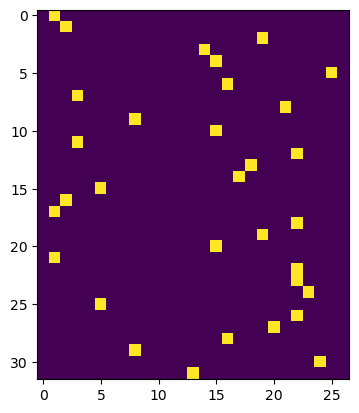

In [170]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [182]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs) # create an array of zeros with the same shape as logprobs
dlogprobs[range(n), Yb] = -1.0/n 

dprobs = (1.0/probs) * dlogprobs # chain rule

dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True) # sum along the first dimension to get the same shape as counts_sum_inv

dcounts_sum = (-1.0 * counts_sum **-2) * dcounts_sum_inv

dcounts = dprobs * counts_sum_inv + dcounts_sum.expand_as(counts)           #counts_sum[i][0] = sum(counts[i][:]), so ∂counts_sum[i][0] / ∂counts[i][j] = 1
# dcounts = torch.ones_like(counts) * dcounts_sum 

dnorm_logits = counts * dcounts

dlogits = dnorm_logits.clone()        # dlogits will be exact copy of norm_logits - refer book & not a final derivative of logits
dlogit_maxes = (- dnorm_logits).sum(1, keepdim=True)    # similarly dlogit_maxes will be negative of dnorm-logits because of the sign. Since logit_maxes is a column 
                                                        #and since we keep replicating the same elements of logit_maxes(n, 1) across all the columns of logits (n, vocab_size), 
                                                        # these are all separate branches using one of the variable of logit_maxes - therefore in backward pass,  we have to do sum of along 1 in order not to destroy that (n, 1) dimensions

#dlogit_maxes =  torch.zeros_like(logits)        # we need to scatter the max values at the right positions from where the max values came
#dlogit_maxes[range(n), Yb] = 1
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0,keepdim=True)         # d=a*b+c, dL/da=dL/dd*b.T ; dL/db = a.T*dL/dd  ; dL/dc = dL/dd.sum(0)  - sum over the rows

dhpreact =  (1 - h**2) * dh       # we know if a = tanh(z) ; da/dz = 1-a**2

dbngain = (bnraw * dhpreact).sum(0, keepdim=True) # during forward pass, we multiplied bngain(1,64) with bnraw(32,64) across the rows. 
                                                    # and in backward pass, we multiply bnraw(32,64) with bhpreact(32,64) and sum across the rows to get dbngain(1,64).

dbnraw = (bngain * dhpreact)
dbnbias = dhpreact.sum(0, keepdim=True)


dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv
#dbndiff2 = (1.0/(n-1))*(torch.ones_like(bndiff2)) * dbnvar
dbndiff2 = (1.0/(n-1)) * dbnvar


dbndiff = (dbnraw * bnvar_inv) + (2.0*bndiff * dbndiff2)

# Broadcasting in the forward pass means  a variable reuse and therefore there will be a sum in the backward pass
dhprebn = dbndiff.clone() # both bndiff and hprebn have the same shape, then local derivatives are equal to 1.0 - simply the gradient copies from dhprebn to dbndiff.
#dbmeani = (- torch.ones_like(bndiff) * dbndiff).sum(0, keepdim=True)
dbnmeani = (-dbndiff).sum(0, keepdim=True)

dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)       # scaling and broadcasting because of the sum over rows in forward pass

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)

# Reset the derivative of the embedding matrix C to zero before accumulating new derivatives.
# This is necessary because in PyTorch, derivatives accumulate by default (i.e., they don't auto-zero after each backward pass).
dC = torch.zeros_like(C)                       
for j in range(n):                                                       # Loop over each item in the batch (there are 'n' examples in total, e.g., 32 if batch size is 32)
    for k in range(block_size):                                          # Loop over each token in the input block (e.g., 3 tokens per input if block_size = 3)
        ix = Xb[j, k]                                                    # Get the index of the k-th token in the j-th example. This index refers to a row in the embedding matrix C.
        dC[ix] += demb[j, k]                                             # Accumulate the derivative for token 'ix' into the corresponding row of dC. demb[j][k] is the derivative of the loss w.r.t. C[ix], so we add it to that row.
                                                                         # If the same token appears multiple times in the batch, this adds up all their contributions.


cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff', dbndiff, bndiff)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [172]:
# Forward pass of cross-entropy loss
# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()
# after:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.2870399951934814 diff: 2.384185791015625e-07


In [173]:
# Backward pass of cross-entropy loss

dlogits = F.softmax(logits, dim=1) # softmax along the rows left to right
dlogits [range(n), Yb] -= 1      # at the right positions, subtract 1. 
dlogits /=n                      # divide by n to scale down the gradient by n.

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 1.1059455573558807e-08


Intuitively, `dlogits` represents the gradient of the loss with respect to the logits (the raw output scores before softmax) for each example in your batch.

- It tells you how much you need to change each logit to decrease the loss.
- In classification, if the predicted probability for the correct class is too low, the corresponding entry in `dlogits` will be negative (indicating you should increase that logit).
- For incorrect classes, the gradient will be positive or zero, suggesting you should decrease those logits.

In summary:  
**`dlogits` shows the direction and amount to nudge each logit to make the model's predictions better (i.e., to reduce the loss).**

- The logit is the probabilities matrix in the forward pass before the softmax. In below plot black squares are the positions of the correct indices where we subtracted a 1.
- If we take the first row of probabilities (softmax), and the derivative dlogits' first row (multiplied by n to make everything interpretable), both are exaclty same except the position of the correct index (which is ~-1)
- If we take sum of first row of dlogits (dlogits[0].sum()), we can see below it is ~0. THis is because the fabric of probabilities of correct index and wrong indices are in the opposite directions. 1 is pushing up and all others are pulling down. This is equalized becasue the sum is zero. And eventually we get a tug on the weights and biases o that pulley mechanism. In each update, we tug in the direction we like and the parameters are giving in to the tug.
- The force we are applying is proportional to the probabilities that came out in forward pass. For example, if our probs came out exactly correct, there would only be one 1 at correct position and all others exactly zeroes. No push and pull.
- The amount ehihc our prediction is incorrect is exactly the amount by which we're going to get a pull or push in that dimension.

In [174]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [175]:
F.softmax(logits, dim=1)[0]

tensor([0.0399, 0.0414, 0.0350, 0.0391, 0.0355, 0.0402, 0.0353, 0.0369, 0.0347,
        0.0373, 0.0376, 0.0381, 0.0372, 0.0368, 0.0379, 0.0338, 0.0325, 0.0356,
        0.0345, 0.0385, 0.0386, 0.0360, 0.0359, 0.0403, 0.0389, 0.0364, 0.0361],
       grad_fn=<SelectBackward0>)

In [176]:
dlogits[0] * n

tensor([ 0.0399,  0.0414,  0.0350,  0.0391,  0.0355,  0.0402,  0.0353,  0.0369,
        -0.9653,  0.0373,  0.0376,  0.0381,  0.0372,  0.0368,  0.0379,  0.0338,
         0.0325,  0.0356,  0.0345,  0.0385,  0.0386,  0.0360,  0.0359,  0.0403,
         0.0389,  0.0364,  0.0361], grad_fn=<MulBackward0>)

In [177]:
dlogits[0].sum()

tensor(9.3132e-10, grad_fn=<SumBackward0>)

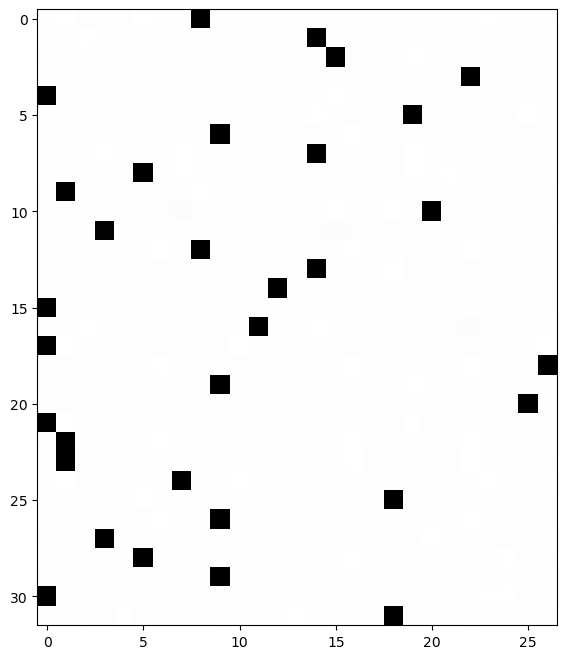

In [178]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')


In [181]:
# Forward pass of BatchNorm layer
# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True) = hprebn.mean(0, keepdim=True)
# bndiff = hprebn - bnmeani = hprebn - hprebn.mean(0, keepdim=True)
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n) = hprebn.var(0, keepdim=True, unbiased=True)
# bnvar_inv = (bnvar + 1e-5)**-0.5 = 1.0/torch.sqrt(bnvar + 1e-5)
# bnraw = bndiff * bnvar_inv = (hprebn - hprebn.mean(0, keepdim=True)))/torch.sqrt(bnvar + 1e-5)
# hpreact = bngain * bnraw + bnbias = bngain * (hprebn - hprebn.mean(0, keepdim=True))/torch.sqrt(bnvar + 1e-5) + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True))/torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff: ', (hpreact_fast - hpreact).abs().max())

max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [186]:
# Backward pass of BatchNorm layer

# before we had:
# dbnraw = bngain * dhpreact 
# dbndiff = bnvar_inv * dbnraw = bnvar_inv * bngain * dhpreact
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True) = ((hprebn - bnmeani) * (bngain * dhpreact)).sum(0, keepdim=True) #from forward pass
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv = (-0.5*(bnvar + 1e-5)**-1.5) * ((hprebn - bnmeani) * (bngain * dhpreact)).sum(0, keepdim=True)
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar = (1.0/(n-1)) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2 = (2*(hprebn - bnmeani)) * dbndiff2 
# Total dbndiff = bnvar_inv * bngain * dhpreact + (2*(hprebn - bnmeani)) * dbndiff2 
#               = bngain * bnvar_inv * dhpreact + dbndiff2 * (2*(hprebn - bnmeani))
#               = bngain * bnvar_inv * dhpreact + ((1.0/(n-1)) * dbnvar) * (2*(hprebn - bnmeani))
#               = bngain * bnvar_inv * dhpreact + ((1.0/(n-1)) * (-0.5*(bnvar + 1e-5)**-1.5) * ((hprebn - bnmeani) * (bngain * dhpreact)).sum(0, keepdim=True)) * (2*(hprebn - bnmeani))
#               = bngain * bnvar_inv * dhpreact - (1/(n-1)) * (hprebn - bnmeani) * ((bnvar + 1e-5)**-1.5) * ((hprebn - bnmeani) * (bngain * dhpreact)).sum(0, keepdim=True))
# dhprebn = dbndiff.clone()         
# dbnmeani = (-dbndiff).sum(0) 
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani) 
# Total dhprebn = dbndiff + 1.0/n * dbnmeani) = dbndiff - 1.0/n * dbndiff.sum(0) 
#               = [bngain * bnvar_inv * dhpreact - (1/(n-1)) * (hprebn - bnmeani) * ((bnvar + 1e-5)**-1.5) * ((hprebn - bnmeani) * (bngain * dhpreact)).sum(0, keepdim=True))] - 1.0/n * [bngain * bnvar_inv * dhpreact - (1/(n-1)) * (hprebn - bnmeani) * ((bnvar + 1e-5)**-1.5) * ((hprebn - bnmeani) * (bngain * dhpreact)).sum(0, keepdim=True))].sum(0)
#               Let A = bngain * bnvar_inv * dhpreact
#	            	B = (1 / (n-1)) * (hprebn - bnmeani) * (bnvar + 1e-5)**-1.5 * ((hprebn - bnmeani) * (bngain * dhpreact)).sum(0)             
#               dhprebn = A - B - (1/n) * (A - B).sum(0)
#                       = A - B - (1/n) * A.sum(0) + (1/n) * B.sum(0)
#                       = A - (1/n) * A.sum(0) - B + (1/n) * B.sum(0)
#                       = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))   # expanding and factoring above equation
# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-11


In [195]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd)                    , generator=g)                                # embedding matrix

print(C.shape)
#Layer 1
fan_in = n_embd * block_size                                                                          # number of input units
W1 = torch.randn((fan_in, n_hidden)        , generator=g) * ((5/3) / (fan_in ** 0.5))                 # weights initialized to small values to avoid bias in the initial loss
b1 = torch.randn(n_hidden                               , generator=g) * 0.01                        # useless cz of the batch norm. bias initialized to small values to avoid bias in the initial loss
# Layer 2
W2 = torch.randn((n_hidden, vocab_size)                 , generator=g) * 0.01                         # weights initialized to small values because we want to avoid bias in the initial loss
b2 = torch.randn(vocab_size                             , generator=g) * 0                            # bias initialized to zero becasue we want to avoid bias in the initial loss
# Batch normalization parameters
bngain = torch.ones(1, n_hidden)*0.1 + 1.0  # batch normalization gain
bnbias = torch.zeros(1, n_hidden)*0.1  # batch normalization bias

# Note: Initializing many of these parameters in non-standard ways because
#       sometimes initializing with e.g. all zeros could mask an incorrect 
#       implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]  # list of all parameters
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True  # enable gradient computation for these parameters


# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():
    # kick off optimization
  for i in range(max_steps):
     # minibatch construct
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # manual Batch norm layer - forward pass -  we can now inspect and compare intermediate gradients at every stage
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    # Backward pass of cross-entropy loss

    dlogits = F.softmax(logits, dim=1) # softmax along the rows left to right
    dlogits [range(n), Yb] -= 1      # at the right positions, subtract 1. 
    dlogits /=n                      # divide by n to scale down the gradient by n.

    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)         # d=a*b+c, dL/da=dL/dd*b.T ; dL/db = a.T*dL/dd  ; dL/dc = dL/dd.sum(0)  - sum over the rows

    # Tanh layer
    dhpreact =  (1 - h**2) * dh       # we know if a = tanh(z) ; da/dz = 1-a**2

    # batchnorm layer backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

    # linear layerdembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)                       
    for j in range(n):                                                       # Loop over each item in the batch (there are 'n' examples in total, e.g., 32 if batch size is 32)
        for k in range(block_size):                                          # Loop over each token in the input block (e.g., 3 tokens per input if block_size = 3)
            ix = Xb[j, k]                                                    # Get the index of the k-th token in the j-th example. This index refers to a row in the embedding matrix C.
            dC[ix] += demb[j, k]                                             # Accumulate the derivative for token 'ix' into the corresponding row of dC. demb[j][k] is the derivative of the loss w.r.t. C[ix], so we add it to that row.
                                                                             # If the same token appears multiple times in the batch, this adds up all their contributions.
    # -----------------
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable
    
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #if i >= 100: # TODO: delete early breaking when you're ready to train the full net
      #break

torch.Size([27, 10])
Number of parameters: 12297
      0/ 200000: 3.3157
  10000/ 200000: 2.1739
  20000/ 200000: 2.2650
  30000/ 200000: 2.3968
  40000/ 200000: 1.9447
  50000/ 200000: 2.4589
  60000/ 200000: 2.5885
  70000/ 200000: 2.0133
  80000/ 200000: 2.3359
  90000/ 200000: 2.1335
 100000/ 200000: 2.0120
 110000/ 200000: 2.3745
 120000/ 200000: 2.0171
 130000/ 200000: 2.5168
 140000/ 200000: 2.4345
 150000/ 200000: 2.2161
 160000/ 200000: 2.0581
 170000/ 200000: 1.8481
 180000/ 200000: 2.2266
 190000/ 200000: 1.7829


In [196]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [197]:
# Calibrate the batch norm at the end of the training - 
# this calculates and sets the batch mean and standard deviation a single timeover the training set

with torch.no_grad():
    # pass the training set through
    emb = C[Xtrain]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # get the preactivation for every example
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [198]:
# evaluate train and val loss

@torch.no_grad() # decorator disable gradient computation for evaluation
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    } [split] # get the data for the split
    emb = C[x] # embedding lookup - (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True) + 1e-5) + bnbias # take every single neuron and its exact firing rate will be exaclty unit gaussian
    hpreact = bngain * (hpreact - bnmean) / (bnvar + 1e-5)**-0.5 + bnbias # take every single neuron and its exact firing rate will be exaclty unit gaussian
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # output layer (N, vocab_size)
    loss = F.cross_entropy(logits, y) # compute loss
    print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 2.4859
val loss: 2.5557


In [199]:
# sample from the model
g= torch.Generator().manual_seed(2147483647)  # for reproducibility

for _ in range(20):
    out = []
    context = [0] * block_size  # start with a context of zeros
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])]  # get the embedding for the context
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2  # output layer
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)  # convert to probabilities
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()  # sample from the distribution
        if ix == 0: break  # stop if we hit the end token
        out.append(itos[ix])  # append the character to the output
        context = context[1:] + [ix]  # update the context

    print(''.join(out))  # print the generated name

junide
jayckarous
fay
adin
kai
rono
sabellee
kalinaa
zamilena
jadeyaine
amel
sera
evy
artellarmunthif
demij
pontel
jarsani
cora
yarion
kaelandreed
